In [1]:
! pip install numpy scipy matplotlib seaborn numpyro jax torch "scikit-learn" "scikit-learn-extra"

# Application: Toy Model of Superposition

- Counting vertices in convex hull. Can refine? Need refining? 
- Visualisation. 
- Structure of the clumps in tSNE. 
- 
  
 
 
Would like to write version with `plotly` or `bokeh` to visualise individual polygons in MCMC samples. 

In [ ]:
import torch
import numpy as np
import jax.numpy as jnp
from jax import random
import jax
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
import scipy

import matplotlib
import matplotlib.pyplot as plt

import functools
import gc

from toymodel_mcmc import (
    ToyModelsDataset, 
    build_model, 
    count_convhull_vertices, 
    compute_l2_distance, 
    normalize_W,
    toymodel_log_likelihood
)
from mcmc_utils import (
    MCMCConfig, 
    linspaced_itemps_by_n, 
    run_mcmc, 
    rlct_estimate_regression, 
    plot_polygon, 
    plot_rlct_regression, 
    count_convhull_vertices, 
    make_tally, 
    generate_2d_ngon_vertices, 
    compute_bayesian_loss, 
    compute_functional_variance, 
    compute_gibbs_loss, 
    compute_waic, 
    compute_wbic, 
)

# CONFIGURATION

In [56]:
rngseed = 5
m = 2
n = 6
num_training_data = 1000
num_test_data = 10000

num_posterior_samples = 1000
num_warmup = 500
num_chains = 2
thinning = 2

prior_std = 1.0
prior_center_k = None
sigma_obs = 1.0

In [69]:

# set rngseeds
np.random.seed(rngseed)
torch.manual_seed(rngseed)
rng_key = random.PRNGKey(rngseed)

####################################################
# Generate data
####################################################
X = jnp.array(ToyModelsDataset(num_samples=num_training_data, n=n, gamma=100).data)
X_test = jnp.array(ToyModelsDataset(num_samples=num_test_data, n=n, gamma=100).data)

####################################################
# Run MCMC
####################################################
mcmc_config = MCMCConfig(
    num_posterior_samples, num_warmup, num_chains, thinning
)
if prior_center_k is not None:
    prior_center = generate_2d_ngon_vertices(args.prior_center_k, rot=np.pi / 4, pad_to=n)
else:
    prior_center = None
model = build_model(m, n, prior_w_center=prior_center, prior_std=prior_std, sigma_obs=sigma_obs)
mcmc = run_mcmc(model, X, rng_key, mcmc_config)
posterior_samples = mcmc.get_samples()

/Users/edmund/Desktop/phd_research/slt_workshop_2023/slt_alignment_workshop_2023_demo/mcmc_utils.py:86: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
INFO:__main__:Running MCMC
sample: 100%|███████████████████| 1500/1500 [00:05<00:00, 252.04it/s, 127 steps of size 3.93e-02. acc. prob=0.89]


In [70]:
Ws = posterior_samples["W"]
num_mcmc_samples = len(Ws)
bs = posterior_samples["b"] # TODO: handle cases where --no_bias is set. 


# - Convex hull configurations
convhull_vertices_nums = [count_convhull_vertices(W) for W in Ws]
convhull_vertices_tally = make_tally(convhull_vertices_nums)

print(f"Num MCMC samples: {num_mcmc_samples}")
num_unique_convexhull = len(set(convhull_vertices_nums))
n_cluster = num_unique_convexhull

print(f"Distinct convex hulls (num={num_unique_convexhull}): {sorted(set(convhull_vertices_nums))}")

# - Frobenius norms
frobenius_norms = np.array([np.sum(W**2) for W in Ws])

# - Clustering
vecs = np.array([W.flatten() for W in Ws])

metric = lambda W1, W2: compute_l2_distance(W1, W2, m=m, normalise_func=normalize_W)
kmedoids = KMedoids(n_clusters=n_cluster, metric=metric).fit(vecs)
cluster_centers = kmedoids.cluster_centers_


# t-SNE for visualization
print("Running tSNE...")
tsne = TSNE(n_components=2, metric=metric)
vecs_2d = tsne.fit_transform(vecs)

Num MCMC samples: 1000
Distinct convex hulls (num=2): [5, 6]
Running tSNE...


In [71]:
log_likelihood_fn = jax.jit(functools.partial(
        toymodel_log_likelihood, sigma_obs=sigma_obs
    ))

loglike_array = np.hstack(# dimension = (num test samples, num mcmc samples)
    [log_likelihood_fn(Ws[i], bs[i], X_test) for i in range(len(Ws))]
)
gibbs_loss = compute_gibbs_loss(loglike_array)
print(f"Gibbs loss: {gibbs_loss}")

bayes_loss = compute_bayesian_loss(loglike_array)
print(f"Bayes loss: {bayes_loss}")
del loglike_array
gc.collect()

loglike_array = np.hstack( 
    [log_likelihood_fn(Ws[i], bs[i], X) for i in range(len(Ws))]
)

gibbs_train_loss = compute_gibbs_loss(loglike_array)
print(f"Gibbs train loss: {gibbs_train_loss}")

bayes_train_loss = compute_bayesian_loss(loglike_array)
print(f"Bayes train loss: {bayes_train_loss}")

func_var = compute_functional_variance(loglike_array)
print(f"Functional Variance: {func_var}")

waic = compute_waic(loglike_array)
print(f"WAIC: {waic}")

# clean up memory intensive variable.
del loglike_array
gc.collect()

Gibbs loss: 0.9245584607124329
Bayes loss: 0.9244219035961047
Gibbs train loss: 0.9244921803474426
Bayes train loss: 0.9243604181109756
Functional Variance: 0.00026407313998788595
WAIC: 0.9246244912509635


0

Text(0.5, 1.0, 'Distribution of $m / ||W||^2$')

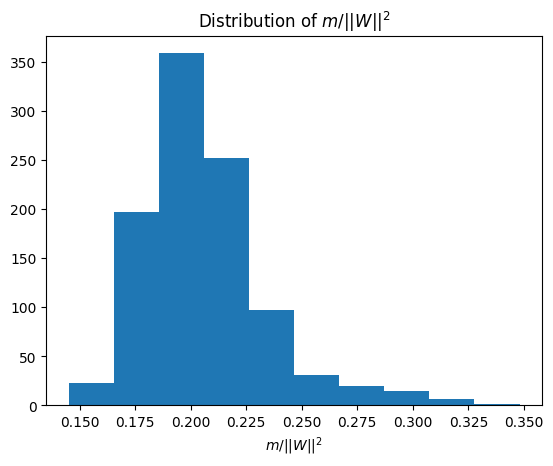

In [72]:
font = {"size": 10}
matplotlib.rc("font", **font)

fig, ax = plt.subplots()
ax.hist(2 / frobenius_norms)
ax.set_xlabel("$m / ||W||^2$")
ax.set_title("Distribution of $m / ||W||^2$")


Text(0.5, 1.0, 'Frequency of number of vertices in convex hull')

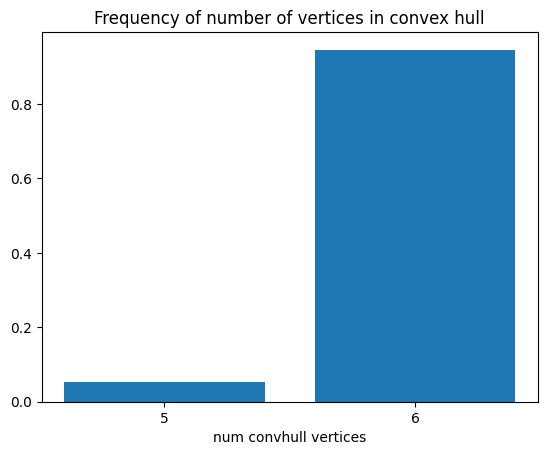

In [73]:
fig, ax = plt.subplots()
keys = sorted(convhull_vertices_tally.keys())
vals = np.array([convhull_vertices_tally[k] for k in keys])
assert len(convhull_vertices_nums) == len(Ws) == sum(vals)
ax.bar(keys, vals / sum(vals))
ax.set_xticks(keys)
ax.set_xlabel("num convhull vertices")
ax.set_title("Frequency of number of vertices in convex hull")


INFO:__main__:Running RLCT estimation regression
INFO:__main__:Sequence of itemps: [0.10581733 0.12529108 0.14476483 0.16423858 0.18371233]
/Users/edmund/Desktop/phd_research/slt_workshop_2023/slt_alignment_workshop_2023_demo/mcmc_utils.py:86: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
INFO:__main__:Running MCMC
sample: 100%|████████████████████| 1500/1500 [00:01<00:00, 835.57it/s, 31 steps of size 1.46e-01. acc. prob=0.88]
INFO:__main__:Total number of MCMC samples: 1000
INFO:__main__:Number of MCMC chain: 4
INFO:__main__:Number of MCMC samples per chain: 250
INFO:__main__:Chain 0 with size 250 has enll 5620.3662109375.
INFO:__main__:Chain 1 with size 250 has enll 5619.365722656

<Axes: title={'center': 'n=1000, L_n=5.562'}, xlabel='Temperature', ylabel='Expected NLL'>

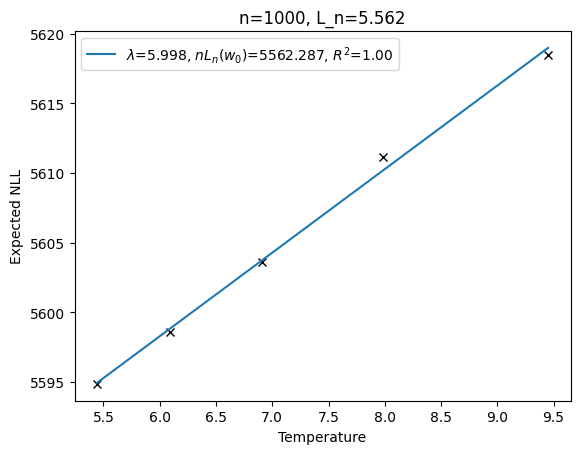

In [74]:
fig, ax = plt.subplots()
itemps = linspaced_itemps_by_n(
    num_training_data, num_itemps=5
)
enlls, stds = rlct_estimate_regression(
    itemps,
    rng_key,
    model,
    jax.jit(lambda W, b, X: log_likelihood_fn(W, b, X).sum()),
    X,
    mcmc_config,
    progress_bar=True
)
slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
plot_rlct_regression(itemps, enlls, num_training_data, ax)

Text(0.5, 1.0, 'tSNE custom metric (color by num vertices in convex hull)')

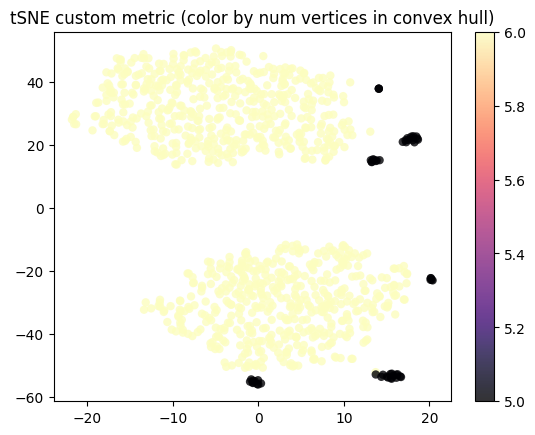

In [75]:
fig, ax = plt.subplots()
cmap = matplotlib.colormaps["magma"]
p = ax.scatter(
    vecs_2d[:, 0],
    vecs_2d[:, 1],
    c=convhull_vertices_nums,
    alpha=0.8,
    linewidth=0.0,
    cmap=cmap,
)
fig.colorbar(p, ax=ax)
ax.set_title(f"tSNE custom metric (color by num vertices in convex hull)")
